<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>

<h1 align=center><font size = 5> Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!curl -o loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23101  100 23101    0     0  59385      0 --:--:-- --:--:-- --:--:-- 59385


### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date']=pd.to_datetime(df['due_date'])
df['effective_date']=pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

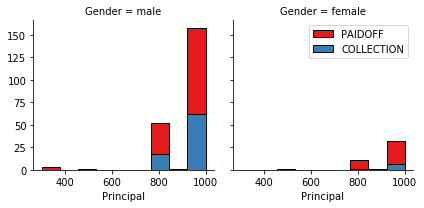

In [8]:
import seaborn as sns

bins=np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

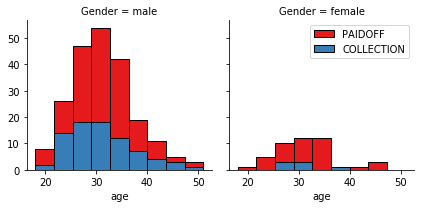

In [9]:
bins=np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

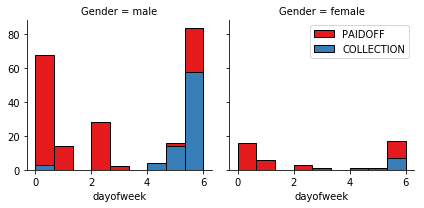

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins=np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature=df[['Principal','terms','age','Gender','weekend']]
Feature=pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

Encode the target column

In [19]:
#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#y = encoder.fit_transform(y)
#y[0:5]

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [22]:
len(X_train), len(X_test), len(y_train), len(y_test)

(259, 87, 259, 87)

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You can find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [24]:
n = 3
clf_knn = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
clf_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [25]:
y_pred = clf_knn.predict(X_test)
y_pred[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

[0.59770115 0.5862069  0.70114943 0.68965517 0.73563218 0.74712644
 0.74712644 0.73563218 0.72413793 0.68965517 0.72413793 0.71264368
 0.71264368 0.73563218]


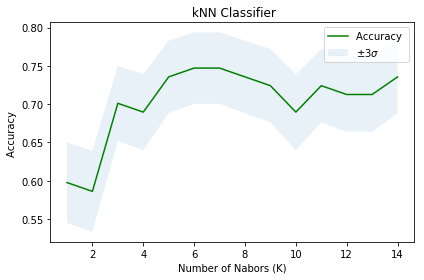

In [26]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1, Ks):
    knn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)    
    std_acc[n-1]  = np.std(y_pred == y_test)/np.sqrt(y_pred.shape[0])
print(mean_acc)

plt.plot(range(1, Ks),mean_acc,'g')
plt.fill_between(range(1, Ks), mean_acc - 1*std_acc, mean_acc + 1*std_acc, alpha=0.10)
plt.legend(('Accuracy ', r'$\pm 3\sigma$'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.title(' kNN Classifier')
plt.tight_layout()
plt.show()

$k=7$ gives the highest accuracy for the KNN classifier.

# Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
clf_tree.fit(X_train, y_train)
clf_tree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [28]:
y_pred = clf_tree.predict(X_test)
#score_tree = metrics.accuracy_score(y_test, y_pred) 
#print(' Decision Tree accuracy: {0:12.7f}'.format(score_tree))
print(y_pred)

['PAIDOFF' 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION']


# Support Vector Machine

In [29]:
from sklearn import svm
clf_svm = svm.SVC()
clf_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
y_pred = clf_svm.predict(X_test)
print(y_pred)

['PAIDOFF' 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION']


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

deg = 10
mean_acc = np.zeros((deg-1))
std_acc = np.zeros((deg-1))
for n in range(1, deg):
    poly_kernel_svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=n, coef0=2, C=5))
    )) 
    poly_kernel_svm_clf.fit(X, y)
    
    y_pred = poly_kernel_svm_clf.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)    
    std_acc[n-1]  = np.std(y_pred == y_test)/np.sqrt(y_pred.shape[0])
print(mean_acc)

plt.plot(range(1, deg),mean_acc,'g')
plt.fill_between(range(1, deg), mean_acc - 1*std_acc, mean_acc + 1*std_acc, alpha=0.10)
plt.legend(('Accuracy ', r'$\pm 3\sigma$'))
plt.ylabel('Accuracy ')
plt.xlabel('Degree of polynomial')
plt.title(' Polynomial Kernel SVM Classifier')
plt.tight_layout()
plt.show()

Although polynomial kernel with degree > 6 gives the best accuracy, we may want to choose a somewhat lower degree to reduce overfitting.

# Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
clf_logit = LogisticRegression(C=0.01)
clf_logit.fit(X_train, y_train)
clf_logit

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
y_pred = clf_logit.predict(X_test)
#score_tree = metrics.accuracy_score(y_test, y_pred) 
#print(' Logistic Regression accuracy: {0:12.7f}'.format(score_tree))
print(y_pred)

['PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION']


# Model Evaluation using Test set

First, download and load the test set:

In [33]:
!curl -o loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3642  100  3642    0     0   9634      0 --:--:-- --:--:-- --:--:--  9634


### Load Test set for evaluation 

In [34]:
df = pd.read_csv('loan_test.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


#### Preprocessing and feature extration

In [35]:
# Convert datatime format
df['due_date']=pd.to_datetime(df['due_date'])
df['effective_date']=pd.to_datetime(df['effective_date'])

# Weekend feature
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
#df.head()

In [36]:
# Binary encode gender
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#df.head()

In [37]:
# One-hot encode categorical features
Feature=df[['Principal','terms','age','Gender','weekend']]
Feature=pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
#Feature.head()

In [38]:
X = Feature
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

Encode the target column for score computation

In [39]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [ ]:
#encoder = LabelEncoder()
#y_encoded = encoder.fit_transform(y)
#y_encoded[0:54]

In [40]:
X.shape, y.shape

((54, 8), (54,))

---
### Import classifier metrics

In [41]:
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_similarity_score as jsc 

#### kNN Classifier

In [44]:
# Recall that K=7 gives the best kNN classifier.
K = 7
clf_knn = KNeighborsClassifier(n_neighbors = K).fit(X_train, y_train)
y_pred = clf_knn.predict(X)
f1_knn = f1_score(y, y_pred, average='weighted')
jsc_knn = jsc(y, y_pred)
print(' kNN classifier (k={0:2d}) scores:'.format(K))
print('       Jaccard: {0:12.6f}'.format(jsc_knn))
print('            f1: {0:12.6f}'.format(f1_knn))

 kNN classifier (k= 7) scores:
       Jaccard:     0.722222
            f1:     0.687101


#### Decision Tree Classifier

In [46]:
y_pred = clf_tree.predict(X)
f1_tree = f1_score(y, y_pred, average='weighted')
jsc_tree = jsc(y, y_pred)
print(' Decision Tree scores:')
print('       Jaccard: {0:12.6f}'.format(jsc_tree))
print('            f1: {0:12.6f}'.format(f1_tree))

 Decision Tree scores:
       Jaccard:     0.722222
            f1:     0.710576


#### Support Vector Machine Classifier with the default RBF kernel

In [47]:
y_pred = clf_svm.predict(X)
f1_svm = f1_score(y, y_pred, average='weighted')
jsc_svm = jsc(y, y_pred)
print(' Support Vector Machine scores:')
print('       Jaccard: {0:12.6f}'.format(jsc_svm))
print('            f1: {0:12.6f}'.format(f1_svm))

 Support Vector Machine scores:
       Jaccard:     0.796296
            f1:     0.770541


#### Logistic Regression

In [48]:
y_pred = clf_logit.predict(X)
y_prob = clf_logit.predict_proba(X) # Need probability to compute log loss
f1_logit = f1_score(y, y_pred, average='weighted')
jsc_logit = jsc(y, y_pred)
logloss_logit = log_loss(y, y_prob)
print(' Logistic Regression scores:')
print('       Jaccard: {0:12.6f}'.format(jsc_logit))
print('            f1: {0:12.6f}'.format(f1_logit))
print('      log loss: {0:12.6f}'.format(logloss_logit))

 Logistic Regression scores:
       Jaccard:     0.796296
            f1:     0.742704
      log loss:     0.574678


In [ ]:
kNN classifier (k= 7) scores:
       Jaccard:     0.722222
            f1:     0.687101
Decision Tree scores:
       Jaccard:     0.722222
            f1:     0.710576
Support Vector Machine scores:
       Jaccard:     0.796296
            f1:     0.770541
Logistic Regression scores:
       Jaccard:     0.796296
            f1:     0.742704
      log loss:     0.574678                

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7222  | 0.6871   | NA      |
| Decision Tree      | 0.7222  | 0.7105   | NA      |
| SVM                | 0.7962  | 0.7705   | NA      |
| LogisticRegression | 0.7962  | 0.7427   | 0.5746  |

## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)


<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>